In [1]:
#!pip install climpred[complete]
#!pip install numpy==1.22

In [2]:
import climpred

import xarray as xr

#climpred.show_versions()

/home/aspring/.local/lib/python3.8/site-packages/pandas/compat/_optional.py:161: UserWarning: Pandas requires version '1.3.1' or newer of 'bottleneck' (version '1.2.1' currently installed).
  warnings.warn(msg, UserWarning)


# Prepare inputs for `climpred`

## observations

In [3]:
obs = xr.open_dataset("/data/volume_2/observational/preprocessed/chirps_tp_2000-2020_4weekly_0.25deg_africa.nc", use_cftime=True)
obs = obs.rename({"__xarray_dataarray_variable__":"tp"}) # metadata missing # dataarray/variable name missing
obs

<xarray.Dataset>
Dimensions:     (latitude: 292, longitude: 278, valid_time: 1113)
Coordinates:
  * latitude    (latitude) float64 -35.38 -35.12 -34.88 ... 36.88 37.12 37.38
  * longitude   (longitude) float64 -17.88 -17.62 -17.38 ... 50.88 51.12 51.38
  * valid_time  (valid_time) object 2000-01-17 00:00:00 ... 2021-01-15 00:00:00
Data variables:
    tp          (valid_time, latitude, longitude) float32 ...

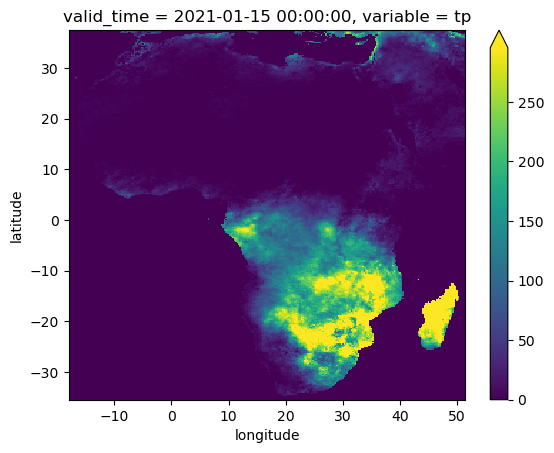

In [4]:
obs.isel(valid_time=-1).to_array().plot(robust=True)

`climpred` observations requires dimension `time`: https://climpred.readthedocs.io/en/stable/setting-up-data.html

In [5]:
obs = obs.rename({"valid_time":"time"})

## initialized

In [6]:
init = xr.open_dataset("/data/volume_2/subseasonal/ecmwf/aggregated/hindcast/ecmwf-hindcast-tp-week3456.nc", use_cftime=True)
init = init.rename({"__xarray_dataarray_variable__":"tp"})
init

<xarray.Dataset>
Dimensions:      (realization: 11, latitude: 121, longitude: 240,
                  valid_time: 1060)
Coordinates:
  * realization  (realization) int64 0 1 2 3 4 5 6 7 8 9 10
  * latitude     (latitude) float64 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
  * longitude    (longitude) float64 0.0 1.5 3.0 4.5 ... 354.0 355.5 357.0 358.5
  * valid_time   (valid_time) object 2000-01-17 00:00:00 ... 2020-01-15 00:00:00
Data variables:
    tp           (valid_time, realization, latitude, longitude) float32 ...

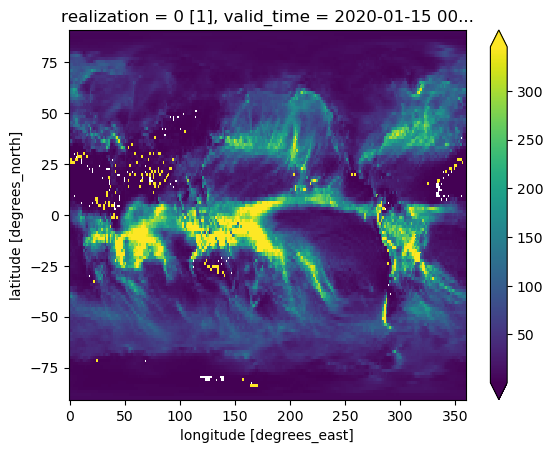

In [7]:
init.isel(realization=0,valid_time=-1).to_array().plot(robust=True)

`climpred` requires dimensions `init` as `forecast_reference_time` and `lead` as `forecast_period`: https://climpred.readthedocs.io/en/stable/setting-up-data.html

In [8]:
import pandas as pd
lead = pd.Timedelta("14 days")
# drop valid_time which gets recreated by HindcastEnsemble
init = init.assign_coords(lead=[lead], init=init.valid_time-lead).swap_dims({"valid_time":"init"}).drop("valid_time")

In [9]:
init 

<xarray.Dataset>
Dimensions:      (realization: 11, latitude: 121, longitude: 240, init: 1060,
                  lead: 1)
Coordinates:
  * realization  (realization) int64 0 1 2 3 4 5 6 7 8 9 10
  * latitude     (latitude) float64 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
  * longitude    (longitude) float64 0.0 1.5 3.0 4.5 ... 354.0 355.5 357.0 358.5
  * lead         (lead) timedelta64[ns] 14 days
  * init         (init) object 2000-01-03 00:00:00 ... 2020-01-01 00:00:00
Data variables:
    tp           (init, realization, latitude, longitude) float32 ...

# select area

In [10]:
# subselect africa
init = init.sel(longitude=slice(0,52),latitude=slice(38,-36)) #  lat -36,38 should have worked but didnt

In [11]:
# interpolate on same grid
# init = init.interp_like(obs) # all 0.25 deg
obs = obs.interp_like(init).astype("float32") # all 1.5 deg

# `climpred.HindcastEnsemble`

## ROC-AUC

In [37]:
group = "month"
# edges separate drought from no draught
model_edges = (
    he.get_initialized().squeeze()
    .groupby(f"init.{group}")
    .quantile(q=[1 / 3], dim=["init", "member"], skipna=True)
    .rename({"quantile": "category_edge"})
)

obs_edges = (
    he.get_observations().squeeze()
    .groupby(f"time.{group}")
    .quantile(q=[1 / 3], dim="time", skipna=True)
    .rename({"quantile": "category_edge"})
)

/home/aspring/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


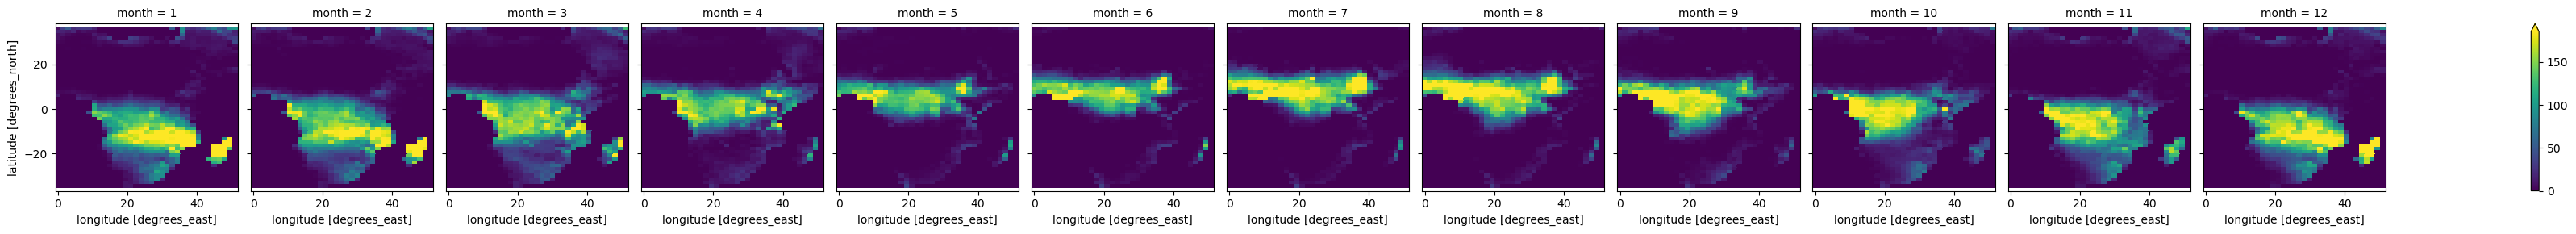

In [38]:
obs_edges.to_array().plot(col="month",robust=True)

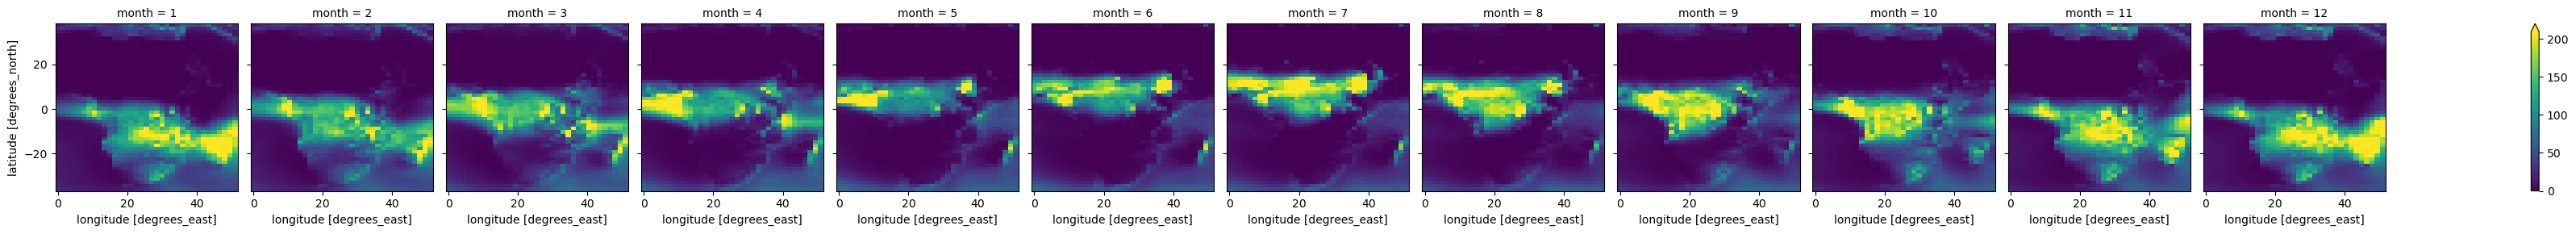

In [39]:
model_edges.to_array().plot(col="month",robust=True)

In [40]:
# probabilistic ensemble members to probabilities
initialized_p = xr.concat(
[
    init.groupby(f"init.{group}") < model_edges, # lower / drought
    init.groupby(f"init.{group}") > model_edges # above
],"category"
)
hep = climpred.HindcastEnsemble(initialized_p)

obs_p = xr.concat(
[
    obs.groupby(f"time.{group}") < obs_edges, # drought
    obs.groupby(f"time.{group}") > obs_edges
],"category"
)

hep = hep.add_observations(obs_p)

/home/aspring/.local/lib/python3.8/site-packages/climpred/checks.py:202: UserWarning: Did not find dimension "member", but renamed dimension realization with CF-complying standard_name "realization" to member.
  warnings.warn(
/home/aspring/.local/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/home/aspring/.local/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]


In [48]:
hep #.sel(init=slice("2000","2004")) # xarray calls work on both datasets

climpred.HindcastEnsemble

<Initialized Ensemble>
Dimensions: (member: 11, latitude: 50, longitude: 35, lead: 1,
 init: 1060, category_edge: 1, category: 2)
Coordinates:
 * member (member) int64 0 1 2 3 4 5 6 7 8 9 10
 * latitude (latitude) float64 37.5 36.0 34.5 33.0 ... -33.0 -34.5 -36.0
 * longitude (longitude) float64 0.0 1.5 3.0 4.5 ... 46.5 48.0 49.5 51.0
 * lead (lead) float64 2.0
 * init (init) object 2000-01-03 00:00:00 ... 2020-01-01 00:00:00
 * category_edge (category_edge) float64 0.3333
 month (init) int64 1 1 1 1 1 2 2 2 2 ... 11 11 11 11 12 12 12 12 1
 valid_time (lead, init) object 2000-01-17 00:00:00 ... 2020-01-15 00:...
Dimensions without coordinates: category
Data variables:
 tp (category, init, member, latitude, longitude, category_edge) bool ... Initialized Ensemble Dimensions: member : 11 latitude : 50 longitude : 35 lead : 1 init : 1060 category_edge : 1 category : 2 Coordinates: (8) member (member) int64 0 1 2 3 4 5 6 7 8 9 10 long_name : Member units : 1 standard_name : realization description : Realization is used to label a dimension that can be thought of as a statistical sample, e.g., labelling members of a model ensemble. array([ 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]) latitude (latitude) float64 37.5 36.0 34.5 ... -34.5 -36.0 units : degrees_north standard_name : latitude long_name : latitude stored_direction : decreasing amip : latitude description : Latitude is positive northward; its units of degree_north (or equivalent) indicate this explicitly. In a latitude-longitude system defined with respect to a rotated North Pole, the standard name of grid_latitude should be used instead of latitude. Grid latitude is positive in the grid-northward direction, but its units should be plain degree. array([ 37.5, 36. , 34.5, 33. , 31.5, 30. , 28.5, 27. , 25.5, 24. ,
 22.5, 21. , 19.5, 18. , 16.5, 15. , 13.5, 12. , 10.5, 9. ,
 7.5, 6. , 4.5, 3. , 1.5, 0. , -1.5, -3. , -4.5, -6. ,
 -7.5, -9. , -10.5, -12. , -13.5, -15. , -16.5, -18. , -19.5, -21. ,
 -22.5, -24. , -25.5, -27. , -28.5, -30. , -31.5, -33. , -34.5, -36. ]) longitude (longitude) float64 0.0 1.5 3.0 4.5 ... 48.0 49.5 51.0 units : degrees_east standard_name : longitude long_name : longitude amip : longitude description : Longitude is positive eastward; its units of degree_east (or equivalent) indicate this explicitly. In a latitude-longitude system defined with respect to a rotated North Pole, the standard name of grid_longitude should be used instead of longitude. Grid longitude is positive in the grid-eastward direction, but its units should be plain degree. array([ 0. , 1.5, 3. , 4.5, 6. , 7.5, 9. , 10.5, 12. , 13.5, 15. , 16.5,
 18. , 19.5, 21. , 22.5, 24. , 25.5, 27. , 28.5, 30. , 31.5, 33. , 34.5,
 36. , 37.5, 39. , 40.5, 42. , 43.5, 45. , 46.5, 48. , 49.5, 51. ]) lead (lead) float64 2.0 units : weeks standard_name : forecast_period long_name : Lead description : Forecast period is the time interval between the forecast reference time and the validity time. A period is an interval of time, or the time-period of an oscillation. array([2.]) init (init) object 2000-01-03 00:00:00 ... 2020-01-... standard_name : forecast_reference_time long_name : Initialization description : The forecast reference time in NWP is the "data time", the time of the analysis from which the forecast was made. It is not the time for which the forecast is valid; the standard name of time should be used for that time. array([cftime.DatetimeProlepticGregorian(2000, 1, 3, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(2000, 1, 10, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(2000, 1, 17, 0, 0, 0, 0, has_year_zero=True),
 ...,
 cftime.DatetimeProlepticGregorian(2019, 12, 18, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(2019, 12, 25, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(2020, 1, 1, 0, 0, 0, 0, has_year_zero=True)],
 dtype=object) category_edge (category_edge) float64 0.3333 array([0.333333]) month (init) int6

<Observations>
Dimensions: (time: 1113, latitude: 50, longitude: 35, category_edge: 1,
 category: 2)
Coordinates:
 * time (time) object 2000-01-17 00:00:00 ... 2021-01-15 00:00:00
 * latitude (latitude) float64 37.5 36.0 34.5 33.0 ... -33.0 -34.5 -36.0
 * longitude (longitude) float64 0.0 1.5 3.0 4.5 ... 46.5 48.0 49.5 51.0
 * category_edge (category_edge) float64 0.3333
 month (time) int64 1 1 1 2 2 2 2 3 3 3 ... 11 11 12 12 12 12 1 1 1
Dimensions without coordinates: category
Data variables:
 tp (category, time, latitude, longitude, category_edge) bool ... Observations Dimensions: time : 1113 latitude : 50 longitude : 35 category_edge : 1 category : 2 Coordinates: (5) time (time) object 2000-01-17 00:00:00 ... 2021-01-... array([cftime.DatetimeProlepticGregorian(2000, 1, 17, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(2000, 1, 24, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(2000, 1, 31, 0, 0, 0, 0, has_year_zero=True),
 ...,
 cftime.DatetimeProlepticGregorian(2021, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(2021, 1, 8, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(2021, 1, 15, 0, 0, 0, 0, has_year_zero=True)],
 dtype=object) latitude (latitude) float64 37.5 36.0 34.5 ... -34.5 -36.0 units : degrees_north standard_name : latitude long_name : latitude stored_direction : decreasing array([ 37.5, 36. , 34.5, 33. , 31.5, 30. , 28.5, 27. , 25.5, 24. ,
 22.5, 21. , 19.5, 18. , 16.5, 15. , 13.5, 12. , 10.5, 9. ,
 7.5, 6. , 4.5, 3. , 1.5, 0. , -1.5, -3. , -4.5, -6. ,
 -7.5, -9. , -10.5, -12. , -13.5, -15. , -16.5, -18. , -19.5, -21. ,
 -22.5, -24. , -25.5, -27. , -28.5, -30. , -31.5, -33. , -34.5, -36. ]) longitude (longitude) float64 0.0 1.5 3.0 4.5 ... 48.0 49.5 51.0 units : degrees_east standard_name : longitude long_name : longitude array([ 0. , 1.5, 3. , 4.5, 6. , 7.5, 9. , 10.5, 12. , 13.5, 15. , 16.5,
 18. , 19.5, 21. , 22.5, 24. , 25.5, 27. , 28.5, 30. , 31.5, 33. , 34.5,
 36. , 37.5, 39. , 40.5, 42. , 43.5, 45. , 46.5, 48. , 49.5, 51. ]) category_edge (category_edge) float64 0.3333 array([0.333333]) month (time) int64 1 1 1 2 2 2 2 ... 12 12 12 12 1 1 1 array([1, 1, 1, ..., 1, 1, 1]) Data variables: (1) tp (category, time, latitude, longitude, category_edge) bool False False False ... False False array([[[[[False],
 [False],
 [False],
 ...,
 [False],
 [False],
 [False]],

 [[ True],
 [ True],
 [ True],
 ...,
 [False],
 [False],
 [False]],

 [[ True],
 [ True],
 [ True],
 ...,
...
 ...,
 [False],
 [False],
 [False]],

 [[False],
 [False],
 [False],
 ...,
 [False],
 [False],
 [False]],

 [[False],
 [False],
 [False],
 ...,
 [False],
 [False],
 [False]]]]]) Attributes: (0)

In [42]:
%%time
# https://climpred.readthedocs.io/en/stable/metrics.html?highlight=roc#climpred.metrics._roc
# https://xskillscore.readthedocs.io/en/stable/api/xskillscore.roc.html
skill = hep.verify(metric='roc', comparison='e2o', dim=["category"], alignment='same_verifs',
                  bin_edges="continuous", return_results="area")

<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


CPU times: user 7.18 s, sys: 926 ms, total: 8.11 s
Wall time: 8.11 s


In [43]:
skill

<xarray.Dataset>
Dimensions:        (init: 1060, latitude: 50, longitude: 35)
Coordinates:
  * init           (init) object 2000-01-03 00:00:00 ... 2020-01-01 00:00:00
  * latitude       (latitude) float64 37.5 36.0 34.5 33.0 ... -33.0 -34.5 -36.0
  * longitude      (longitude) float64 0.0 1.5 3.0 4.5 ... 46.5 48.0 49.5 51.0
    category_edge  float64 0.3333
    lead           float64 2.0
    month          (init) int64 1 1 1 1 1 2 2 2 2 ... 11 11 11 11 12 12 12 12 1
    valid_time     (init) object 2000-01-17 00:00:00 ... 2020-01-15 00:00:00
    skill          <U11 'initialized'
Data variables:
    tp             (init, latitude, longitude) float64 0.0 0.0 0.0 ... 0.0 0.0
Attributes:
    prediction_skill_software:     climpred https://climpred.readthedocs.io/
    skill_calculated_by_function:  HindcastEnsemble.verify()
    number_of_members:             11
    alignment:                     same_verifs
    metric:                        roc
    comparison:                    e2o
    dim:                           ['category']
    reference:                     []
    bin_edges:                     continuous
    return_results:                area

In [44]:
group = "season"

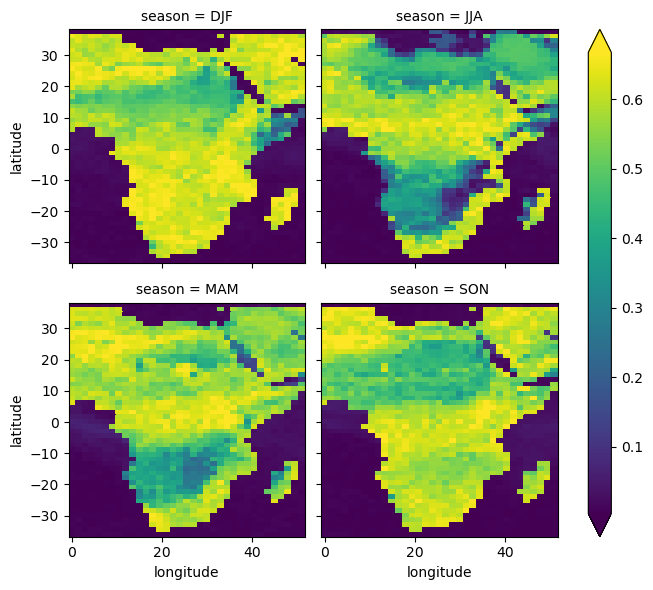

In [45]:
skill = skill.to_array().groupby(f"init.{group}").mean()
skill.plot(col=group, col_wrap=2, robust=True)

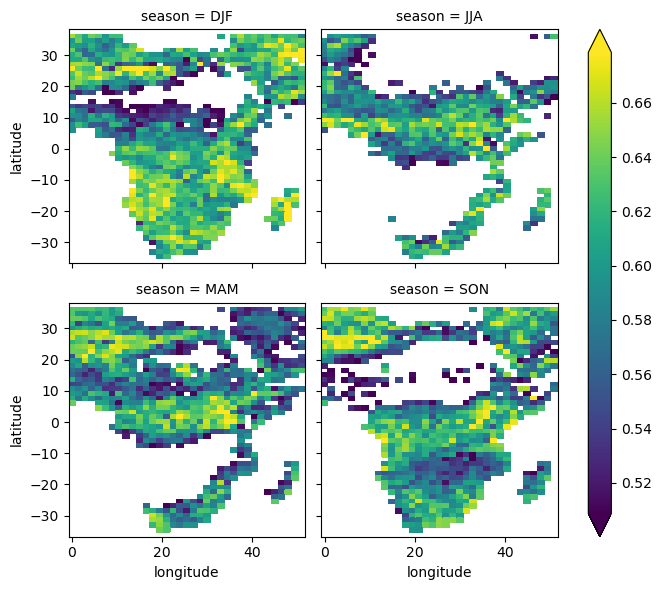

In [46]:
skill.where(skill>.5).plot(col=group, col_wrap=2, robust=True)